In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy import optimize

import logging


In [3]:
import qt3utils.experiments.rabi
from qt3utils.analysis.rabi import signal_to_background
import qt3utils.analysis.aggregation
import qt3utils.nidaq
import qcsapphire
import qt3rfsynthcontrol

# Set Logging Levels

This controls output print statements, which can be useful for debugging and knowing that scans are running

In [4]:
logging.basicConfig(level=logging.WARNING)

In [5]:
qt3utils.experiments.rabi.logger.setLevel(logging.INFO)

# Create objects to control hardware

In [6]:
pulser = qcsapphire.Pulser('COM4')
rfsynth = qt3rfsynthcontrol.QT3SynthHD('COM5')

In [7]:
nidaq_config = qt3utils.nidaq.EdgeCounter('Dev1')

# Define a number of useful functions for later

In [9]:
def aggregate_mean_data(data_buffer, rabi):
    '''
    Calls qt3utils.analysis.aggregation.reshape_sum_trace, where
        cwodmr.N_cycles = N_rows
        cwodmr.N_clock_ticks_per_cycle = N_samples_per_row

    '''
    return qt3utils.analysis.aggregation.reshape_mean_trace(data_buffer,
                                                           rabi.N_cycles,
                                                           rabi.N_clock_ticks_per_cycle)

In [10]:
def recombine_scans(set_of_scans):
    #creates dictionary where key = rf_width, and value is an empty numpy array
    #that will be filled in the loop below
    combined_scans = {s[0]:np.zeros(s[1].shape[0]) for s in set_of_scans[0]}

    for scan in set_of_scans:
        for read in scan:
            width = read[0]
            data = read[1]
            combined_scans[width] += data #add the data from the scan to the approprate array 

    #transform the combined_scans dictionary to a list of lists in the same format as the data from each single scan. 
    reconstructed_scan = [[s, combined_scans[s]] for s in sorted(list(combined_scans.keys()))]
    return reconstructed_scan

In [11]:
def plot_rolled_trace(trace, N_cycles=1, clock_rate=1, shift=0):
    trace = np.roll(trace,shift)
    plt.plot(np.arange(len(trace)) / clock_rate, trace/N_cycles * clock_rate)

In [12]:
def signal_to_background(trace, pre_trigger, aom_width, rf_width, post_rf_pad, verbose=False,
                        signal_aom_width_duty = 1.0, background_aom_width_duty = 1.0,
                        aggregation = np.sum):
    '''
    Assumes trace produced by qt3utils.experiments.rabi.Rabi class and
    is the aggregated data for a particular RF width.

    The inputs `pre_trigger`, `aom_width` and `rf_width` are all in units of index of the trace.
    That is, they are in units of clock ticks.

    Assumes that trace is of shape
        * pre_trigger
        * aom_width: aom on / rf off (background)
        * rf_width:  aom off / rf on
        * aom_width: aom on/ rf off  (signal)

    returns sum(signal) / sum(background)

    '''
    background_end = pre_trigger + int(aom_width*background_aom_width_duty)
    signal_start = pre_trigger + aom_width + rf_width + post_rf_pad
    signal_end = signal_start + int(aom_width*signal_aom_width_duty)

    background = aggregation(trace[pre_trigger:background_end])
    signal = aggregation(trace[signal_start:signal_end])

    if verbose:
        print('background')
        print(trace[pre_trigger:background_end])
        print('signal')
        print(trace[signal_start:signal_end])

    return signal / background



In [13]:
def build_contrast(single_scan, pre_trigger = 2, signal_duty=0.5, background_duty=0.5):

    contrast = []

    for measurement in single_scan:

        rf_width_time = measurement[0]
        N_samples_per_cycle = measurement[1]
        clock_period = rabi.clock_period
        aom_width_time = rabi.aom_width
        summed_trace = measurement[2]

        aom_width_ticks = np.round(aom_width_time / clock_period).astype(int)
        rf_width_ticks = np.round(rf_width_time / clock_period).astype(int)
        post_rf_pad_ticks = np.round(rabi.post_rf_pad / clock_period).astype(int)

        c = signal_to_background(summed_trace, 
                                 pre_trigger, 
                                 aom_width_ticks, 
                                 rf_width_ticks, 
                                 post_rf_pad_ticks,
                                 signal_aom_width_duty = signal_duty, 
                                 background_aom_width_duty = background_duty , aggregation = np.mean)

        contrast.append([rf_width_time, c]) 

    contrast = np.array(contrast)
    return contrast

# Instantiate an experiment object

In [8]:
rabi = qt3utils.experiments.rabi.Rabi(pulser, rfsynth, nidaq_config, rf_width_high = 15e-6, rf_power = -10,
                                     rf_frequency=2873e6)

In [15]:
rabi.experimental_conditions()

{'rf_width_low': 1e-07,
 'rf_width_high': 1.5e-05,
 'rf_width_step': 5e-08,
 'rf_power': -10,
 'rf_frequency': 2873000000.0,
 'aom_width': 3e-06,
 'aom_response_time': 8e-07,
 'rf_response_time': 2e-07,
 'post_rf_pad': 1e-07,
 'pre_rf_pad': 1e-07,
 'full_cycle_width': 2e-05,
 'clock_period': 2e-07}

## Change some parameters if you wish

In [ ]:
#modify these as you see fit

rabi.rf_power = -30
#rabi.aom_width = 5e-6
rabi.rf_width_high = 15e-6
rabi.rf_width_low =  200e-9 #can go as low as 20e-9 and 20e-9 step size!  But if RF power is ~-30dB, 200ns step size is fine
rabi.rf_width_step = 200e-9
rabi.full_cycle_width = rabi.aom_width + rabi.rf_width_high + 1e-6 #make sure our full pulse width cycle is large enough...

# Take Data

In [17]:
#rabi.rf_frequency = 2593e6
#rabi.rf_frequency = 3100e6
#rabi.rfsynth.set_channel_fixed_output(0, rabi.rf_power, rabi.rf_frequency)
rabi.rfsynth.rf_on(rabi.rfsynth_channel)
time.sleep(2)
print(rabi.experimental_conditions())

full_scans = []
N = 1 #for testing
#N = 100 #for statistics

for i in range(N):
    if i % 5 == 0:
        print(i)
    single_scan = rabi.run(N_cycles=1000, post_process_function=aggregate_mean_data, reverse=(1%2==0))
    full_scans.append(single_scan)
 
# single scan mode
#single_scan = rabi.run(N_cycles = 1000, post_process_function=aggregate_mean_data) #very short scan
#single_scan = rabi.run(N_cycles = 100000, post_process_function=aggregate_mean_data) #longer scan

{'rf_width_low': 5e-07, 'rf_width_high': 1.5e-05, 'rf_width_step': 5e-07, 'rf_power': -30, 'rf_frequency': 2873000000.0, 'aom_width': 3e-06, 'aom_response_time': 8e-07, 'rf_response_time': 2e-07, 'post_rf_pad': 1e-07, 'pre_rf_pad': 1e-07, 'full_cycle_width': 2e-05, 'clock_period': 2e-07}
0


INFO:qt3utils.experiments.rabi:RF Width: 5e-07 seconds
INFO:qt3utils.experiments.rabi:RF Width: 1e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 1.5e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 2e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 2.5e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 3e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 3.5e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 4e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 4.5e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 5e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 5.5e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 6e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 6.5e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 7e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 7.5e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 8e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 8.5e-06 seconds
INFO:qt3utils.experiments.rabi:RF Width: 9e-06 se

## Massage Data

In [ ]:
#only need this if doing repeated scans. If just doing one long single scan, can comment this out
reconstructed_single_scan = recombine_scans(full_scans)

# Build contrast

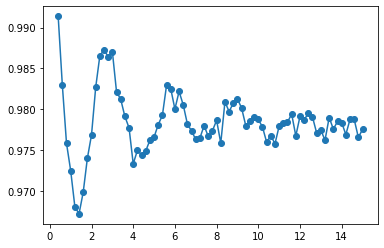

In [20]:
contrast = build_contrast(reconstructed_single_scan)
#contrast = build_contrast(scan_data)

x_data = contrast[:, 0]*1e6
y_data = contrast[:, 1]

plt.plot(x_data, y_data, 'o-', label='Data')

# Perform fit

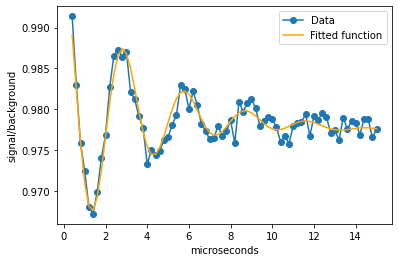

In [22]:
def rabi_oscillation(x, a, b, phi, t, offset, slope):
    return a * np.exp(-x/t) * np.sin(2*np.pi*x/b + phi) + offset + slope * x

params, params_covariance = optimize.curve_fit(rabi_oscillation, x_data, y_data,
                                              p0=[.005, 1, 1, 1, 1, 0], maxfev=50000)
#params, params_covariance = optimize.curve_fit(rabi_oscillation, x_data, y_data, maxfev=5000)


plt.figure(figsize=(6, 4))
#plt.scatter(x_data, y_data, label='Data', s=5)
plt.plot(x_data, y_data, 'o-', label='Data')

plt.xlabel('microseconds')
plt.ylabel('signal/background')
plt.plot(x_data, rabi_oscillation(x_data, *params),
         label='Fitted function', color='orange')
plt.legend()

In [25]:
params[1]/2 #pi pulse in microseconds

1.4753981611551872

In [26]:
params[3] #t2* in microseconds

3.2528610014553894